In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import os
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format  # Display only 2 decimal points

In [2]:
net= pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_net.tntp', skiprows=8, sep='\t').drop(['~', ';'], axis =1)
net['edge']=net.index+1
net['length'] = net.length*5
flow=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_flow.tntp',sep='\t').drop(['From ', 'To '],axis=1)
flow.rename(columns={"Volume ": "flow", "Cost ": "cost"},inplace=True)
node_coord=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_node.tntp',sep='\t').drop([';'], axis=1) # Actual Sioux Falls coordinate
node_xy=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_node_xy.tntp',sep='\t') # X,Y position for good visualization

In [3]:
# dataframe containing all link attributes
sioux_falls_df=pd.concat([net,flow], axis=1)
sioux_falls_df

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,"25,900.20",30,6,0.15,4,0,0,1,1,"4,494.66",6.00
1,1,3,"23,403.47",20,4,0.15,4,0,0,1,2,"8,119.08",4.01
2,2,1,"25,900.20",30,6,0.15,4,0,0,1,3,"4,519.08",6.00
3,2,6,"4,958.18",25,5,0.15,4,0,0,1,4,"5,967.34",6.57
4,3,1,"23,403.47",20,4,0.15,4,0,0,1,5,"8,094.66",4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,"5,000.00",20,4,0.15,4,0,0,1,72,"9,626.21",12.24
72,23,24,"5,078.51",10,2,0.15,4,0,0,1,73,"7,902.98",3.76
73,24,13,"5,091.26",20,4,0.15,4,0,0,1,74,"11,112.39",17.62
74,24,21,"4,885.36",15,3,0.15,4,0,0,1,75,"10,259.52",11.75


In [4]:
def create_graph(sioux_falls_df):
    # Create graph

    G = nx.from_pandas_edgelist(sioux_falls_df, 'init_node', 'term_node',
                                 ['capacity', 'length', 'free_flow_time', 'b', 'power', 'speed',
                                  'toll', 'link_type', 'edge', 'flow', 'cost'],
                                 create_using=nx.MultiDiGraph())

    # Coordinate positions
    pos_coord = {i: (a, b) for i, a, b in zip(node_coord.Node, node_coord.X, node_coord.Y)}
    pos_xy = {i: (a, b) for i, a, b in zip(node_xy.Node, node_xy.X, node_xy.Y)}

    # Assign positions as attributes
    for n, p in pos_coord.items():
        G.nodes[n]['pos_coord'] = p

    for n, p in pos_xy.items():
        G.nodes[n]['pos_xy'] = p

    # Define charging stations
    charging_stations = {2, 6, 12, 16}
    for n in G.nodes:
        G.nodes[n]['charging_station'] = n in charging_stations

    return G, pos_xy, charging_stations

In [5]:
def plot_graph(G, pos):
    plt.figure(figsize=(12, 12))

    # Define node colors
    node_colors = ['red' if G.nodes[n]['charging_station'] else 'blue' for n in G.nodes]

    # Draw graph
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Sioux Falls Network with Charging Stations', fontsize=20)

    # Save figure
    plt.savefig('sioux-falls-network.png')
    plt.show()

In [6]:
def find_all_paths(graph, start_state, goal_state):
    paths = list(nx.all_simple_paths(graph, source=start_state, target=goal_state))
    path_distances = []
    for idx, path in enumerate(paths, start=1):
        distance = sum(graph[path[i]][path[i + 1]][0]['length'] for i in range(len(path) - 1) if graph[path[i]][path[i + 1]])
        path_distances.append((idx, path, distance))
    return path_distances

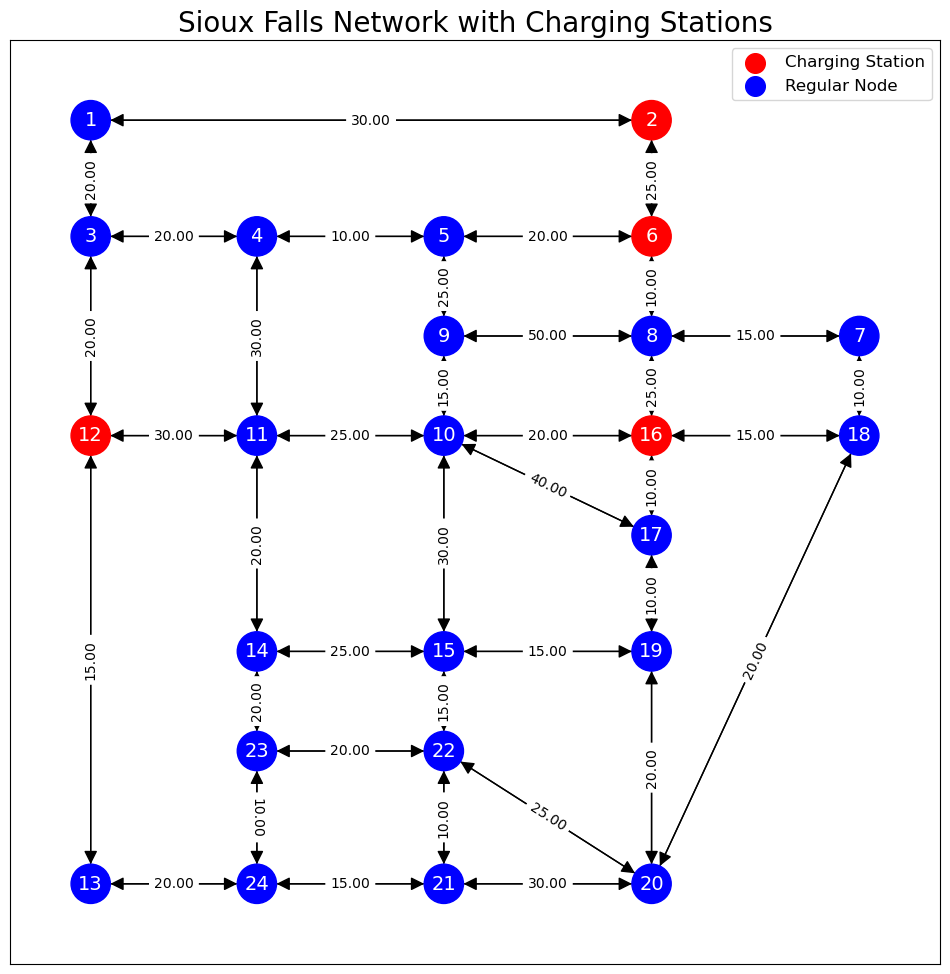

In [7]:
G, pos,charging_stations = create_graph(sioux_falls_df)
plot_graph(G, pos)

In [8]:
all_paths = find_all_paths(G, start_state=1, goal_state=3)

In [9]:
import numpy as np
import networkx as nx
import random

class Q_learning():
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1000, max_steps_per_episode=100):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        # Mapping of charging station IDs to indices for Q-table access
        self.charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
        # Map node IDs to zero-based indices
        self.node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
        
        # Initialize Q-tables later when graph is available
        self.Q_layer1 = None
        self.Q_layer2 = None
    
    def initialize_layer_1(self, num_states, num_actions):
        self.Q_layer1 = np.zeros((num_states, num_actions))
    
    def initialize_layer_2(self, num_states, charging_stations):
        self.Q_layer2 = np.zeros((num_states, len(charging_stations)))
    
    def get_state(self, current_node, SoC):
        return current_node
    
    def choose_action_layer1(self, state, SoC):
        valid_actions = list(self.G.neighbors(state))
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        else:
            valid_q_values = {action: self.Q_layer1[state, action] for action in valid_actions}
            return max(valid_q_values, key=valid_q_values.get)
        
    def choose_action_layer2(self, state, charging_stations):
        if np.random.rand() <= self.epsilon:
            return random.choice(list(charging_stations))
        else:
            valid_q_values = {station: self.Q_layer2[state, station] for station in charging_stations}
            return max(valid_q_values, key=valid_q_values.get)
    
    def calculate_travel_time(self, distance, average_velocity):
        return (distance / average_velocity) * 60




In [10]:
import numpy as np
import networkx as nx
import random

class TrainQlearning(Q_learning):
    def __init__(self, G, average_velocity, initial_SoC, SoC_consumption_rate, charging_capacity, max_cap, battery_capacity_kWh, destination_node, charging_station_properties):
        super().__init__()
        self.G = G
        self.average_velocity = average_velocity
        self.initial_SoC = initial_SoC
        self.SoC_consumption_rate = SoC_consumption_rate
        self.charging_capacity = charging_capacity
        self.max_cap = max_cap
        self.battery_capacity_kWh = battery_capacity_kWh
        self.destination_node = destination_node
        self.charging_station_properties = charging_station_properties
        self.episode_rewards = []
        self.Q_layer1 = self.initialize_layer_1(len(G.nodes()), len(G.nodes()))
        self.Q_layer2 = self.initialize_layer_2(len(G.nodes()), charging_station_properties.keys())
    
    def step_layer1(self, action, current_node, SoC, visited_nodes, path):
        if self.G.has_edge(current_node, action):
            edge_key = next(iter(self.G[current_node][action]))
            distance = self.G[current_node][action][edge_key]['length']
            travel_time = self.calculate_travel_time(distance, self.average_velocity)
            SoC -= distance * self.SoC_consumption_rate
            total_time = travel_time
            reward = -total_time
            next_node = action
        else:
            reward = -1000  # Heavy penalty for invalid action
            next_node = current_node
            total_time = 0
        
        if next_node in visited_nodes:
            reward -= 500
        
        shortest_path_distance = nx.shortest_path_length(self.G, source=next_node, target=self.destination_node, weight='length')
        reward -= shortest_path_distance * 0.1
        
        if not (path and path[-1] == next_node):
            path.append(next_node)
        
        return next_node, SoC, reward, total_time
    
    def step_layer2(self, action, current_node, SoC, path):
        distance_to_station = nx.shortest_path_length(self.G, source=current_node, target=action, weight='length')
        path_to_station = nx.shortest_path(self.G, source=current_node, target=action, weight='length')
        path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])
        
        travel_time = self.calculate_travel_time(distance_to_station)
        charging_time, waiting_time, price_of_charging = self.charging_station_properties[action]
        total_time = travel_time + charging_time + waiting_time
        
        price = price_of_charging * self.charging_capacity * self.battery_capacity_kWh / 100
        SoC = min(self.max_cap, SoC + self.charging_capacity)
        reward = -price
        
        return action, SoC, reward, total_time, price
    
    def train(self):
        for episode in range(self.num_episodes):
            current_node = 1
            SoC = self.initial_SoC
            total_time = 0
            steps = 0
            visited_nodes = set()
            episode_reward = 0
            path = [current_node]
            
            while current_node != self.destination_node and steps < self.max_steps_per_episode:
                state = self.get_state(current_node, SoC)
                if SoC <= 30:
                    action_layer2 = self.choose_action_layer2(state, self.charging_station_properties.keys())
                    next_node, SoC, reward_layer2, time_taken_layer2, price = self.step_layer2(action_layer2, current_node, SoC, path)
                    total_time += time_taken_layer2
                    
                    self.Q_layer2[self.node_to_index[state], self.charging_station_index[action_layer2]] += self.alpha * (
                        reward_layer2 + self.gamma * np.max(self.Q_layer2[self.node_to_index[next_node]]) -
                        self.Q_layer2[self.node_to_index[state], self.charging_station_index[action_layer2]]
                    )
                    episode_reward += reward_layer2
                else:
                    action_layer1 = self.choose_action_layer1(state, SoC)
                    next_node, SoC, reward_layer1, time_taken_layer1 = self.step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
                    total_time += time_taken_layer1
                    
                    self.Q_layer1[self.node_to_index[state], self.node_to_index[action_layer1]] += self.alpha * (
                        reward_layer1 + self.gamma * np.max(self.Q_layer1[self.node_to_index[next_node]]) -
                        self.Q_layer1[self.node_to_index[state], self.node_to_index[action_layer1]]
                    )
                    episode_reward += reward_layer1
                
                visited_nodes.add(current_node)
                current_node = next_node
                steps += 1
                
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            self.episode_rewards.append(episode_reward)
    
    def test(self, current_node):
        SoC = self.initial_SoC
        total_time = 0
        steps = 0
        visited_nodes = set()
        path = [current_node]
        charging_stations_visited = {}
        
        while current_node != self.destination_node and steps < self.max_steps_per_episode:
            state = self.get_state(current_node, SoC)
            if SoC <= 30:
                action_layer2 = self.choose_action_layer2(state, self.charging_station_properties.keys())
                next_node, SoC, _, time_taken_layer2, price = self.step_layer2(action_layer2, current_node, SoC, path)
                total_time += time_taken_layer2
                charging_stations_visited[action_layer2] = (time_taken_layer2, price)
            else:
                action_layer1 = self.choose_action_layer1(state, SoC)
                next_node, SoC, _, time_taken_layer1 = self.step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
                total_time += time_taken_layer1
            
            if next_node == current_node:
                total_time += 10
            
            if not (path and path[-1] == next_node):
                path.append(next_node)
            
            visited_nodes.add(current_node)
            current_node = next_node
            steps += 1
        
        print("Optimal Path:", path)
        print("Total Time to Reach Destination:", total_time, "minutes")
        if charging_stations_visited:
            print("Charging Stations Visited and Time Spent:")
            for station, details in charging_stations_visited.items():
                print(f"Charging Station {station}: {details[0]} minutes, Price: {details[1]}")
        else:
            print("No Charging Stations Visited.")


In [11]:
# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 50 # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.5 # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity

battery_capacity_kWh = 40
destination_node = 24
charging_station_properties = {
    2: (30, 10, 10.10) , 6: (35, 15, 4.40),
    12: (20, 10, 9.50), 16: (30, 5, 10.80)
}


train_evrp = TrainQlearning(G, average_velocity, initial_SoC, SoC_consumption_rate, charging_capacity, max_cap, battery_capacity_kWh, destination_node, charging_station_properties)

In [12]:
train_evrp.train()

TypeError: 'NoneType' object is not subscriptable

In [13]:
# Create a graph with nodes, edges, and charging stations
G, locations, charging_stations = create_graph(sioux_falls_df)

# Hyperparameters for the Q-learning algorithm
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate (initially set to 1 for maximum exploration)
epsilon_decay = 0.995  # Decay rate for epsilon (reduces exploration over time)
epsilon_min = 0.01  # Minimum value for epsilon (ensures some exploration)
num_episodes = 1000  # Number of episodes for training
max_steps_per_episode = 100  # Maximum steps allowed per episode

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 50 # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.5 # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity

battery_capacity_kWh = 40

# Properties of charging stations (station ID: (charging time, waiting time, price of charging electricity))
charging_station_properties = {
    2: (30, 10, 10.10) , 6: (35, 15, 4.40),
    12: (20, 10, 9.50), 16: (30, 5, 10.80)
}

# Mapping of charging station IDs to indices for Q-table access
charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
# Map node IDs to zero-based indices
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}


destination_node =24

In [14]:
# Initialize Q-tables
num_states = G.number_of_nodes()
num_actions = G.number_of_nodes()
Q_layer1 = np.zeros((num_states, num_actions))
Q_layer2 = np.zeros((num_states, len(charging_stations)))

def get_state(current_node, SoC):
    return current_node

def choose_action_layer1(state, SoC):
    valid_actions = list(G.neighbors(state))

    # Filter out actions that lead to already visited nodes
    unexplored_actions = [action for action in valid_actions if action not in visited_nodes]

    if unexplored_actions:  # If there are unexplored actions, prioritize them
        valid_actions = unexplored_actions

    if np.random.rand() <= epsilon:
        return random.choice(valid_actions)  # Exploration: choose a random valid action
    else:
        # Exploitation: choose the action with the highest Q-value
        valid_q_values = {action: Q_layer1[node_to_index[state], node_to_index[action]] for action in valid_actions}
        return max(valid_q_values, key=valid_q_values.get)

def choose_action_layer2(state):
    if np.random.rand() <= epsilon:
        return random.choice(list(charging_stations))
    else:
        valid_q_values = {station: Q_layer2[node_to_index[state], charging_station_index[station]] for station in charging_stations}
        return max(valid_q_values, key=valid_q_values.get)

def calculate_travel_time(distance):
    return (distance / average_velocity) * 60

def step_layer1(action, current_node, SoC, visited_nodes, path):
    if G.has_edge(current_node, action):
        edge_key = next(iter(G[current_node][action]))
        distance = G[current_node][action][edge_key]['length']
        travel_time = calculate_travel_time(distance)
        SoC -= distance * SoC_consumption_rate
        total_time = travel_time
        reward = -total_time
        next_node = action
    else:
        reward = -1000  # Heavy penalty for invalid action
        next_node = current_node
        total_time = 0

    # Increased penalty for revisiting nodes
    if next_node in visited_nodes:
        reward -= 500  # Increased penalty for revisiting nodes

    # Add a penalty based on the distance to the destination
    shortest_path_distance = nx.shortest_path_length(G, source=next_node, target=destination_node, weight='length')
    reward -= shortest_path_distance * 0.1

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    return next_node, SoC, reward, total_time

def step_layer2(action, current_node, SoC, path, battery_capacity_kWh = 40):
    price = 0
    # Calculate the distance to the charging station
    distance_to_station = nx.shortest_path_length(G, source=current_node, target=action, weight='length')

    # Calculate the required SoC to reach the charging station
    required_SoC = distance_to_station * SoC_consumption_rate

    # Check if the current SoC is sufficient to reach the charging station
    # if SoC < required_SoC:
    #     # Impose a heavy penalty if the SoC is insufficient
    #     reward = -1000  # Heavy penalty for not being able to reach the charging station
    #     total_time = 0  # No time is spent since the vehicle cannot move
    #     next_node = current_node  # Stay at the current node
    #     return next_node, SoC, reward, total_time, price

    # If the SoC is sufficient, proceed with the original logic
    path_to_station = nx.shortest_path(G, source=current_node, target=action, weight='length')
    path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

    # Calculate the travel time to the charging station
    travel_time = calculate_travel_time(distance_to_station)

    # Get charging time and waiting time from the charging station properties
    charging_time, waiting_time, price_of_charging = charging_station_properties[action]

    # Calculate the total time spent (travel + charging + waiting)
    total_time = travel_time + charging_time + waiting_time

    #adding the pricing constraint
    price = price_of_charging*charging_capacity*battery_capacity_kWh/100

    # Update the SoC after charging
    SoC = min(max_cap, SoC + charging_capacity)

    # Calculate the reward (negative of total time)
    #reward = -(total_time+3*price)
    reward = -price

    # Set the next node to the charging station
    next_node = action

    return next_node, SoC, reward, total_time, price

episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()  # Track visited nodes
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)
        if SoC <= 30:
            action_layer2 = choose_action_layer2(state)
            next_node, SoC, reward_layer2, time_taken_layer2, price = step_layer2(action_layer2, current_node, SoC, path)
            total_time += time_taken_layer2
            action_idx = charging_station_index[action_layer2]
            next_state_layer2 = get_state(next_node, SoC)
            Q_layer2[node_to_index[state], action_idx] += alpha * (reward_layer2 + gamma * np.max(Q_layer2[node_to_index[next_state_layer2]]) - Q_layer2[node_to_index[state], action_idx])
            episode_reward += reward_layer2
        else:
            action_layer1 = choose_action_layer1(state, SoC)
            next_node, SoC, reward_layer1, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
            total_time += time_taken_layer1
            next_state_layer1 = get_state(next_node, SoC)
            Q_layer1[node_to_index[state], node_to_index[action_layer1]] += alpha * (reward_layer1 + gamma * np.max(Q_layer1[node_to_index[next_state_layer1]]) - Q_layer1[node_to_index[state], node_to_index[action_layer1]])
            episode_reward += reward_layer1

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    # Decay epsilon for exploration-exploitation trade-off
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    #print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")


    # Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()  # Track visited nodes
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, SoC)
    if SoC <= 30:
        action_layer2 = choose_action_layer2(state)
        next_node, SoC, _, time_taken_layer2, price = step_layer2(action_layer2, current_node, SoC, path)
        total_time += time_taken_layer2
        charging_stations_visited[action_layer2] = (time_taken_layer2, price)
    else:
        action_layer1 = choose_action_layer1(state, SoC)
        next_node, SoC, _, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
        total_time += time_taken_layer1

    # Additional penalty for staying at the same node
    if next_node == current_node:
        total_time += 10  # Additional penalty for staying at the same node

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    # Update visited nodes and current node
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, details in charging_stations_visited.items():
        print(f"Charging Station {station}: {details[0]} minutes {details[1]} price")
else:
    print("No Charging Stations Visited.")


Optimal Path: [6, 5, 4, 11, 4, 5, 6, 2, 1, 3, 12, 13, 12, 3, 1, 2, 6, 8, 16, 17, 19, 15, 19, 17, 16, 8, 6, 2, 6, 5, 9, 10, 15, 19, 17, 16, 8, 6, 2, 6, 5, 4, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 14, 11, 4, 5, 6, 2, 6, 5, 4, 11, 4, 5, 6, 2, 6, 5, 4, 11]
Total Time to Reach Destination: 5173.333333333333 minutes
Charging Stations Visited and Time Spent:
Charging Station 2: 153.33333333333331 minutes 202.0 price


In [17]:
class QLearningBase:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((num_states, num_actions))

    def choose_action(self, state, valid_actions):
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)  # Exploration
        else:
            # Convert valid_actions to indices
            valid_action_indices = [self.node_to_index[action] for action in valid_actions]
            # Get Q-values for valid actions
            valid_q_values = {action: self.Q[self.node_to_index[state], self.node_to_index[action]] for action in valid_actions}
            return max(valid_q_values, key=valid_q_values.get)  # Exploitation

    def update_q_value(self, state, action, reward, next_state):
        state_idx = self.node_to_index[state]
        action_idx = self.node_to_index[action]
        next_state_idx = self.node_to_index[next_state]
        self.Q[state_idx, action_idx] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state_idx]) - self.Q[state_idx, action_idx])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

class EVNavigation(QLearningBase):
    def __init__(self, G, charging_stations, node_to_index, charging_station_index, initial_SoC, max_cap, SoC_consumption_rate, average_velocity, charging_station_properties, max_steps_per_episode=1000):
        super().__init__(G.number_of_nodes(), G.number_of_nodes())
        self.G = G
        self.charging_stations = charging_stations
        self.node_to_index = node_to_index
        self.charging_station_index = charging_station_index
        self.initial_SoC = initial_SoC
        self.max_cap = max_cap
        self.SoC_consumption_rate = SoC_consumption_rate
        self.average_velocity = average_velocity
        self.charging_station_properties = charging_station_properties
        self.max_steps_per_episode = max_steps_per_episode
        self.Q_layer2 = np.zeros((self.num_states, len(charging_stations)))

    def get_state(self, current_node, SoC):
        return current_node

    def calculate_travel_time(self, distance):
        return (distance / self.average_velocity) * 60

    def step_layer1(self, action, current_node, SoC, visited_nodes, path):
        if self.G.has_edge(current_node, action):
            edge_key = next(iter(self.G[current_node][action]))
            distance = self.G[current_node][action][edge_key]['length']
            travel_time = self.calculate_travel_time(distance)
            SoC -= distance * self.SoC_consumption_rate
            total_time = travel_time
            reward = -total_time
            next_node = action
        else:
            reward = -1000  # Heavy penalty for invalid action
            next_node = current_node
            total_time = 0

        if next_node in visited_nodes:
            reward -= 500  # Increased penalty for revisiting nodes

        shortest_path_distance = nx.shortest_path_length(self.G, source=next_node, target=self.destination_node, weight='length')
        reward -= shortest_path_distance * 0.1

        if not (path and path[-1] == next_node):
            path.append(next_node)

        return next_node, SoC, reward, total_time

    def step_layer2(self, action, current_node, SoC, path, battery_capacity_kWh=40):
        price = 0
        distance_to_station = nx.shortest_path_length(self.G, source=current_node, target=action, weight='length')
        required_SoC = distance_to_station * self.SoC_consumption_rate

        path_to_station = nx.shortest_path(self.G, source=current_node, target=action, weight='length')
        path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

        travel_time = self.calculate_travel_time(distance_to_station)
        charging_time, waiting_time, price_of_charging = self.charging_station_properties[action]
        total_time = travel_time + charging_time + waiting_time
        price = price_of_charging * charging_capacity * battery_capacity_kWh / 100
        SoC = min(self.max_cap, SoC + charging_capacity)
        reward = -price
        next_node = action

        return next_node, SoC, reward, total_time, price

    def train(self, num_episodes, destination_node):
        self.destination_node = destination_node
        episode_rewards = []
        for episode in range(num_episodes):
            current_node = 1
            SoC = self.initial_SoC
            total_time = 0
            steps = 0
            visited_nodes = set()
            episode_reward = 0
            path = [current_node]

            while current_node != destination_node and steps < self.max_steps_per_episode:
                state = self.get_state(current_node, SoC)
                if SoC <= 30:
                    action_layer2 = self.choose_action(state, list(self.charging_stations))
                    next_node, SoC, reward_layer2, time_taken_layer2, price = self.step_layer2(action_layer2, current_node, SoC, path)
                    total_time += time_taken_layer2
                    action_idx = self.charging_station_index[action_layer2]
                    next_state_layer2 = self.get_state(next_node, SoC)
                    self.Q_layer2[self.node_to_index[state], action_idx] += self.alpha * (reward_layer2 + self.gamma * np.max(self.Q_layer2[self.node_to_index[next_state_layer2]]) - self.Q_layer2[self.node_to_index[state], action_idx])
                    episode_reward += reward_layer2
                else:
                    action_layer1 = self.choose_action(state, list(self.G.neighbors(current_node)))
                    next_node, SoC, reward_layer1, time_taken_layer1 = self.step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
                    total_time += time_taken_layer1
                    next_state_layer1 = self.get_state(next_node, SoC)
                    self.update_q_value(state, action_layer1, reward_layer1, next_state_layer1)
                    episode_reward += reward_layer1

                visited_nodes.add(current_node)
                current_node = next_node
                steps += 1

            self.decay_epsilon()
            episode_rewards.append(episode_reward)
        return episode_rewards

    def test(self, start_node, destination_node):
        self.destination_node = destination_node
        current_node = start_node
        SoC = self.initial_SoC
        path = [current_node]
        total_time = 0
        steps = 0
        visited_nodes = set()
        charging_stations_visited = {}

        while current_node != destination_node and steps < self.max_steps_per_episode:
            state = self.get_state(current_node, SoC)
            if SoC <= 30:
                action_layer2 = self.choose_action(state, list(self.charging_stations))
                next_node, SoC, _, time_taken_layer2, price = self.step_layer2(action_layer2, current_node, SoC, path)
                total_time += time_taken_layer2
                charging_stations_visited[action_layer2] = (time_taken_layer2, price)
            else:
                action_layer1 = self.choose_action(state, list(self.G.neighbors(current_node)))
                next_node, SoC, _, time_taken_layer1 = self.step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
                total_time += time_taken_layer1

            if next_node == current_node:
                total_time += 10

            if not (path and path[-1] == next_node):
                path.append(next_node)

            visited_nodes.add(current_node)
            current_node = next_node
            steps += 1

        print("Optimal Path:", path)
        print("Total Time to Reach Destination:", total_time, "minutes")
        if charging_stations_visited:
            print("Charging Stations Visited and Time Spent:")
            for station, details in charging_stations_visited.items():
                print(f"Charging Station {station}: {details[0]} minutes {details[1]} price")
        else:
            print("No Charging Stations Visited.")

In [18]:
ev_nav = EVNavigation(G, charging_stations, node_to_index, charging_station_index, initial_SoC, max_cap, SoC_consumption_rate, average_velocity, charging_station_properties)
episode_rewards = ev_nav.train(num_episodes=1000, destination_node=24)
ev_nav.test(start_node=6, destination_node=24)

Optimal Path: [6, 5, 6, 8, 16, 18, 20, 22, 23, 24]
Total Time to Reach Destination: 255.0 minutes
Charging Stations Visited and Time Spent:
Charging Station 16: 81.66666666666666 minutes 216.0 price
